In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import shutil
import pathlib

### Move model to folder (cause .gitignore "data" folder)

In [3]:
pathlib.Path('data/models').mkdir(parents=True, exist_ok=True)
shutil.copyfile('256.h5', 'data/models/256.h5')

'data/models/256.h5'

### Load Model

In [4]:
PATH = 'data/'
arch=resnext50
size = 256
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, size))
learn = ConvLearner.pretrained(arch, data)
learn.load('256')

datasets: [<fastai.dataset.FilesIndexArrayDataset object at 0x7f33d5180358>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f33d5180400>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f33d51804a8>, <fastai.dataset.FilesIndexArrayDataset object at 0x7f33d5180518>, None, None]


### Validation set

In [5]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds,y)

0.9464212678936605

In [6]:
predict_indice = np.argmax(preds, axis=1)

#### data.val_y and y are exactly the same thing.

In [7]:
np.sum(data.val_y != y)

0

#### data.val_ds is raw data

In [8]:
len(data.val_ds), len(data.val_ds[0]), len(data.val_ds[0][0]), len(data.val_ds[0][0][0])

(4890, 2, 3, 256)

### Prediction

In [195]:
def predict(image_path):
    trn_tfms, val_tfms = tfms_from_model(arch, size)
    img = open_image(image_path)
    im = val_tfms(img)
    preds = learn.predict_array(im[None])
    class_index = np.argmax(preds)
    return data.classes[class_index]
print(
    predict('data/valid/convertible/Aston Martin V8 Vantage Convertible 201200239.jpg'),
    predict('data/valid/coupe/Acura Integra Type R 200102742.jpg'),
    predict('data/valid/hatchback/Acura ZDX Hatchback 201200036.jpg')
)


convertible coupe hatchback


In [218]:
import math

def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val(idxs):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    columns = 4
    rows = math.ceil(len(imgs)/columns)
    f = plt.figure(figsize=(16,rows*4)) # total image size 
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, columns, i+1)
        sp.axis('Off')
        
        id = idxs[i]
        title = str(data.val_ds.fnames[id].split('/')[2])+'\n'+ \
                str(probs[id]) + '\n' + \
                'correct:'+str(np.array(data.classes)[y[id]]) + '\n'+\
                'predict:'+str(np.array(data.classes)[predict_indice[id]])
        sp.set_title(title, fontsize=8)
        plt.imshow(imgs[i])

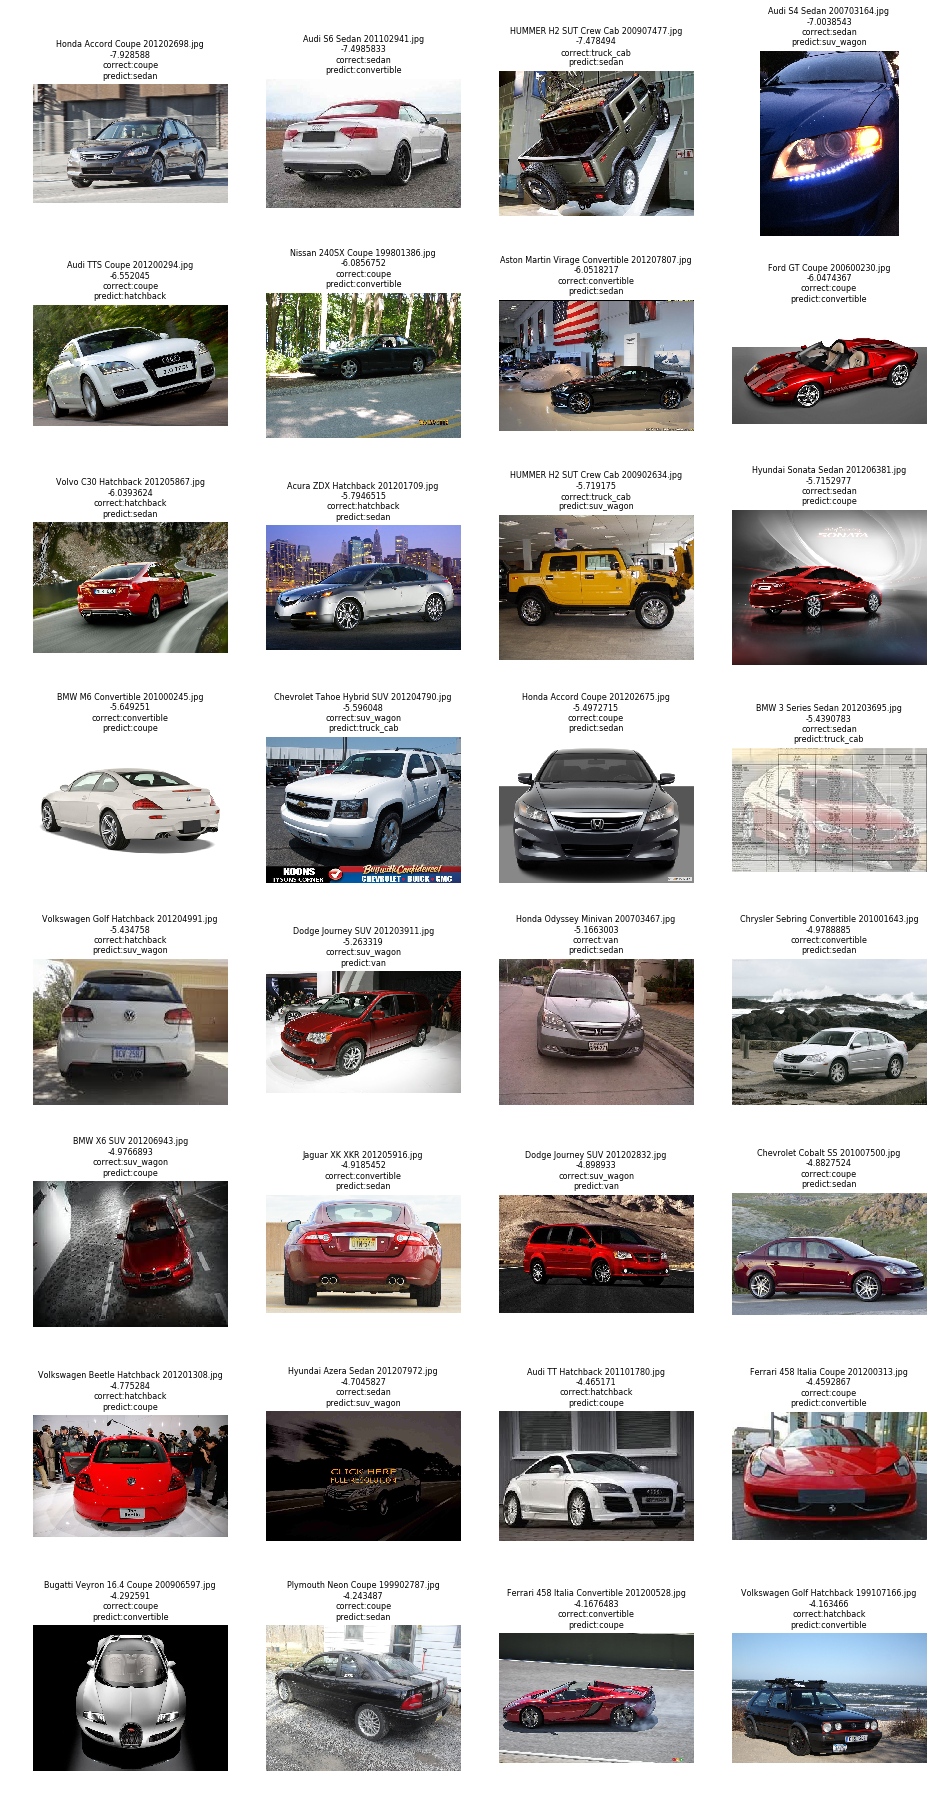

In [219]:
is_correct = False
mask = (predict_indice == y) == is_correct # same as !=
idxs = np.array(np.where(mask)).squeeze()

# map these 2 things to get the losses of the correct classes
# 1. preds[idxs] => list of all losses of each class ex. [[-1.900,-2.123,-1.334...], [..]]
# 2. y[idxs] => indices of correct classes ex. [0,0,0,1,1,..]

probs = np.array(list(map(lambda a,b: a[b], preds, y)))
sorted_idxs = idxs[np.argsort(probs[idxs])]
plot_val(sorted_idxs[:32])


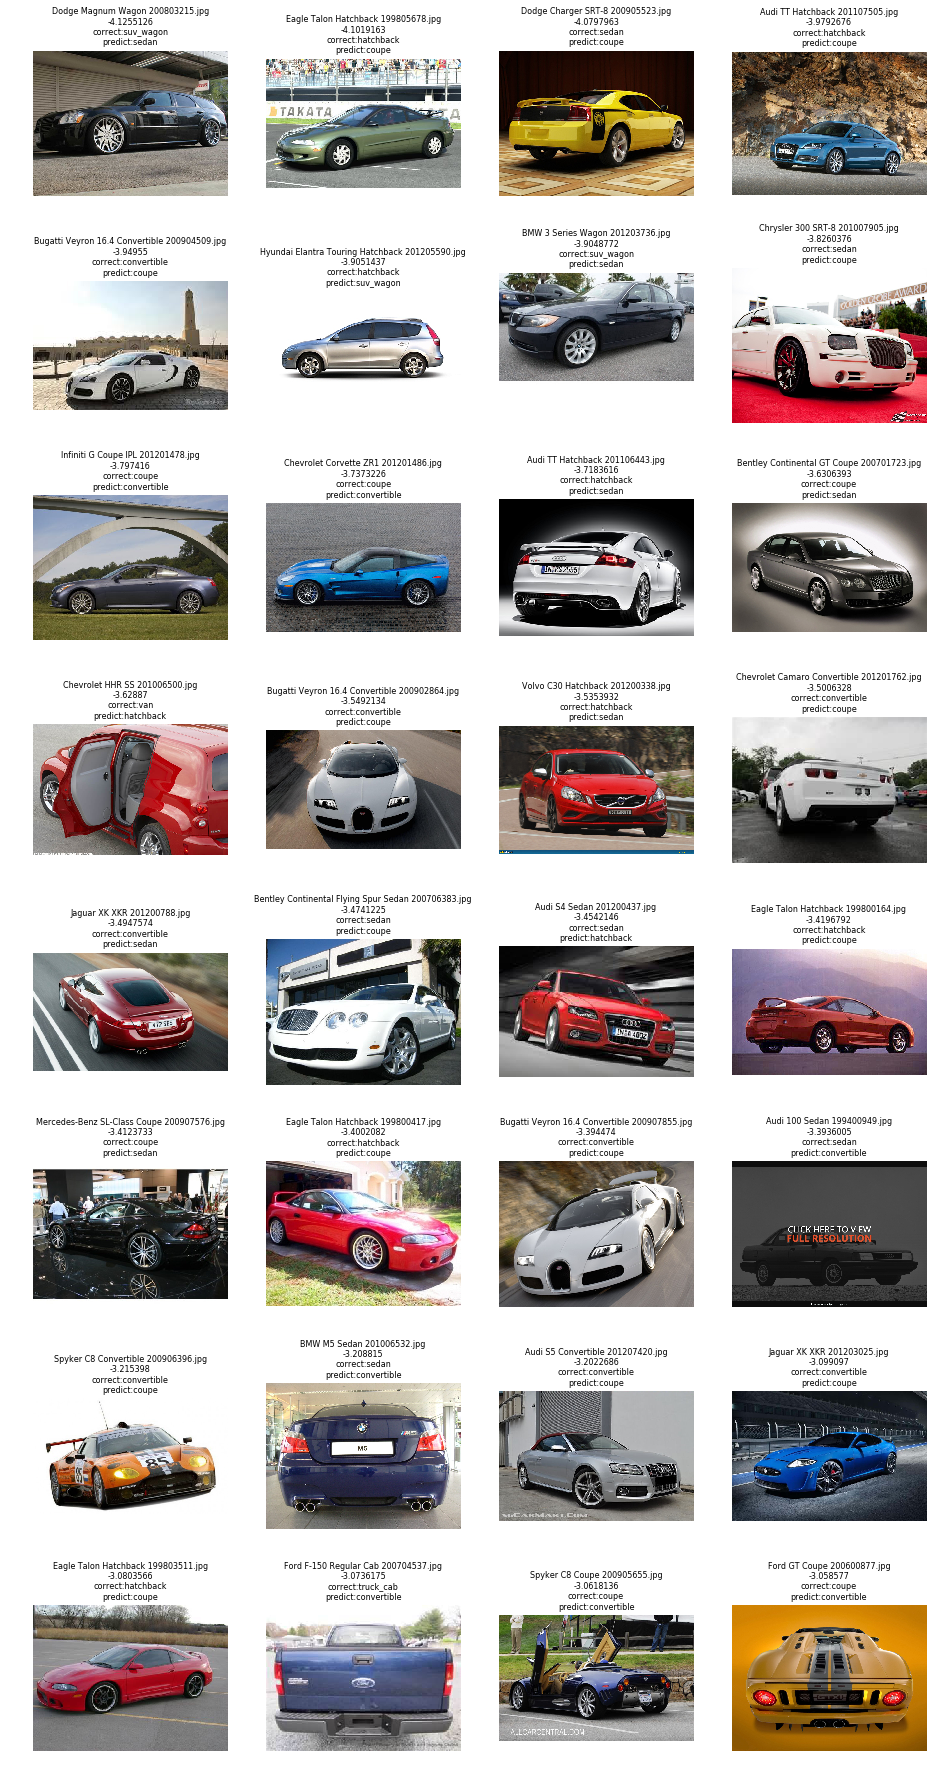

In [220]:
plot_val(sorted_idxs[32:64])